In [ ]:
from GaussianGenerator import GaussianGenerator
import numpy as np
import threading
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import socket
import pandas as pd

In [2]:
DEBUG = True
BACKLOG = 5
HEADERSIZE = 10


class Server:

	def __init__(self, port):
		"""
		Server object that can accept request at port=port
		Create a SOCK_STREAM socket and bind at localhost at port
		"""
		self.s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
		self.s.bind((socket.gethostname(), port))
		self.s.listen(BACKLOG)  # backlog = 5 by default
		self.clientsock = None
		self.clientaddress = None

	def recv(self):
		"""
		Blocking recv. Block to accept and receive.
		:return: msg to be pickled
		"""
		self.clientsock, self.clientaddress = self.s.accept()

		#if DEBUG:
			#print(f"Received message from {self.clientaddress}")

		full_msg = b''
		new_msg = True
		msglen = 0
		while True:  # receive full length
			msg = self.clientsock.recv(16)
			if new_msg:
				msglen += int(msg[:HEADERSIZE])
				new_msg = False
			full_msg += msg
			if len(full_msg) - HEADERSIZE == msglen:
				return pickle.loads(full_msg[HEADERSIZE:])

	def reply(self, msg, port):
		"""
		Reply to msg that we just received from
		:return: num_byte_sent
		"""
		
		loc = (self.clientaddress[0],port)
		return self.send(loc, msg)

	def get_socket(self):
		return self.s

	def send(self, location: (str, str), msgtosend):
		"""
		Send msg to location
		:param location: specify (address, port) to be sent to
		:param msgtosend: the msg will be pickled
		:return:
		"""
		s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
		s.connect(location)
		msg = pickle.dumps(msgtosend)
		msg = bytes(f"{len(msg):<{HEADERSIZE}}", 'utf-8') + msg
		return s.send(msg)


In [3]:
PORT = 1232
serv_model = Server(PORT)
PORT2 = 1233
serv_grad = Server(PORT2)

OSError: [Errno 98] Address already in use

In [4]:
def model_server():
    print("model server thread is up")
    global w
    global stop
    while True:
        if stop:
            break
        result = serv_model.recv()

        #send weights
        serv_model.reply(w, PORT)

In [5]:
def ClassAccuracy(X,Y,w):
	s = 0
	for i in range(X.shape[0]):
		if ((np.dot(w,X[i])>=0 and Y[i]==1) or (np.dot(w,X[i])<0 and Y[i]==-1)):
			s += 1
	s = s/X.shape[0]
	return s

In [6]:
data = pd.read_csv("data_banknote_authentication.txt", header = None)
d_full = data.to_numpy()
np.random.seed(4)
np.random.shuffle(d_full)

#data set
X_full = d_full[:,:4]
Y_full = d_full[:,4]
for i in range(Y_full.shape[0]):
    if Y_full[i]==0:
        Y_full[i] = -1
print(X_full.shape[0])

#test set
X_test = X_full[:274,:]
Y_test = Y_full[:274]
print(X_test.shape)

#validation set
n = 55
X_val = X_full[274:329,:]
Y_val = Y_full[274:329]
print(X_val.shape)

1372
(274, 4)
(55, 4)


# Zeno++

In [23]:
T_Acc = []
F = []

In [ ]:
maxit = 200
k = 10
ns = 20
gamma = 0.1
epsilon = 0.1
rho = 0.002
step = 0
Acc =[]
fp = 0
stop = False
w = np.array([0.0,0.0,0.0,0.0])
th = threading.Thread(target=model_server, daemon=True)
th.start()

while (step < maxit):
    if (step%k==0):
        #updater
        r = np.random.choice(range(X_val.shape[0]), ns)
        x = X_val[r]
        y = Y_val[r]
        #print(f"The sample is {str(x)} with labels {str(y)}")

        v = np.array([0,0,0,0])
        for i in range(ns):
            if ((np.dot(w,x[i])>=0 and y[i]==-1) or (np.dot(w,x[i])<0 and y[i]==1)):
                v = v -np.multiply(y[i],x[i])
                #print(f"There was a misclassification, new grad is {str(v)}")

        v = v/ns
        #print(f"Grad from updater is {str(v)}")

    
    #receive g
    g_tilde = serv_grad.recv()
    #print(f"Received gradient {str(g_tilde)}")
    if (np.linalg.norm(g_tilde)!= 0):
        c = np.linalg.norm(v)/np.linalg.norm(g_tilde)
        g = [c*e for e in g_tilde]
    else:
        g = g_tilde
    if (gamma*np.dot(v,g)-rho*(np.linalg.norm(g)**2)>=-gamma*epsilon):
        u_g = np.array([gamma*e for e in g])
        w = w - u_g
    else:
        #print("Rejected gradient\n")
        fp += 1
        u_g = np.array([gamma*e for e in g])
        w2 = w - u_g

   
    #print(f"New weights are {str(w)}")
    s = ClassAccuracy(X_test, Y_test, w)
    Acc.append(s)
    if len(Acc)>1:
        dif = Acc[len(Acc)-2]-Acc[len(Acc)-1]
    else:
        dif = 1


    step += 1
    


model server thread is up


In [ ]:
T_Acc.append(Acc)
F.append(fp)
T = np.asarray(T_Acc)
print(T.shape)

In [ ]:
np.savetxt("Zeno++acc.csv", T, delimiter = ",")

In [ ]:
fig = plt.figure()
plt.plot(range(len(Acc)),Acc)
plt.show() 

# AsyncSGD

In [9]:
T_Acc = []

In [10]:
maxit = 200
ns = 10
Acc =[]
step = 0
w = np.array([0.0,0.0,0.0,0.0])
stop = False
th = threading.Thread(target=model_server, daemon=True)
th.start()
dif = 1
while (step < maxit):
    #receive g
    g_tilde = serv_grad.recv()
    #print("Received grad")
    w = w - g_tilde
    s = ClassAccuracy(X_test, Y_test, w)
    Acc.append(s)
    if len(Acc)>1:
        dif = Acc[len(Acc)-2]-Acc[len(Acc)-1]
    else:
        dif = 1
    step += 1
stop = True
th.join()

model server thread is up


NameError: name 'serv_grad' is not defined

In [44]:
T_Acc.append(Acc)

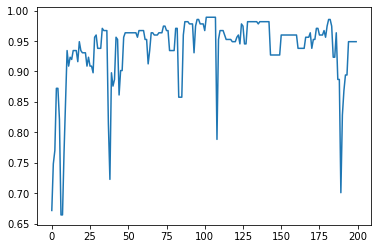

In [45]:
fig = plt.figure()
plt.plot(range(len(Acc)),Acc)
plt.show() 

In [47]:
T = np.asarray(T_Acc)
print(T.shape)
avg_acc = np.mean(np.asarray(T_Acc), axis=0)
print(avg_acc.shape)

(10, 200)
(200,)


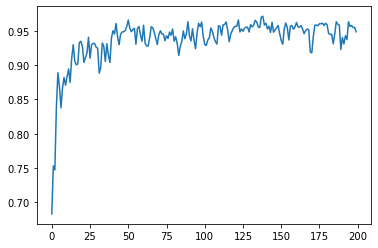

In [48]:
fig = plt.figure()
plt.plot(range(len(avg_acc)),avg_acc)
plt.show() 

In [49]:
np.savetxt("ASGDwo.csv", avg_acc, delimiter = ",")

# ServerOnly

In [27]:
maxit = 200
ns = 10
T_Acc = []
for i in range(10):
    step = 0
    Acc =[]

    w = np.array([0.0,0.0,0.0,0.0])
    while (step < maxit):
        #updater
        r = np.random.choice(range(X_val.shape[0]), ns)
        x = X_val[r]
        y = Y_val[r]
        v = np.array([0,0,0,0])
        for i in range(ns):
            if ((np.dot(w,x[i])>=0 and y[i]==-1) or (np.dot(w,x[i])<0 and y[i]==1)):
                v = v -np.multiply(y[i],x[i])

        v = v/ns


        w = w - v
        s = ClassAccuracy(X_test, Y_test, w)
        Acc.append(s)

        step += 1
    T_Acc.append(Acc)

(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,

KeyboardInterrupt: 

In [24]:
T = np.asarray(T_Acc)
print(T.shape)
avg_acc = np.mean(np.asarray(T_Acc), axis=0)
print(avg_acc.shape)

(10, 200)
(200,)


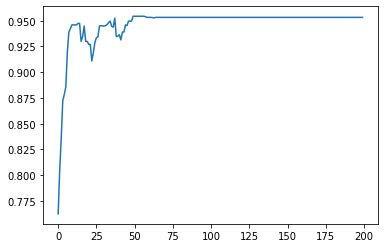

In [25]:
fig = plt.figure()
plt.plot(range(len(avg_acc)),avg_acc)
plt.show() 

In [26]:
np.savetxt("ServerOnly.csv", avg_acc, delimiter = ",")